# Imports

In [259]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import re
import pandas as pd
from tqdm import tqdm

%matplotlib inline

# Generic functions

In [298]:
R1, R2 = 0.6, 0.9
#R1, R2 = 3, 3# радіус кола
def xi(t):
    return np.array([R1*(math.cos(t)+0.65*math.cos(2*t)-0.65), R2*math.sin(t)])

# def xi(t):
#     return np.array([R1*math.cos(t), R2*math.sin(t)])

# def xi_der(t):
#     return np.array([-R1*math.sin(t), R2*math.cos(t)])

def xi_der(t):
    return np.array([R1*(-math.sin(t) - 1.3*math.sin(2*t)), R2*math.cos(t)])

# def xi_der2(t):
#     return np.array([-R1*math.cos(t), -R2*math.sin(t)])

def xi_der2(t):
    return np.array([R1*(-2.6*math.cos(2*t)-math.cos(t)), -R2*math.sin(t)])

def gradPhi(x, y):
    return (x - y) / (2 * np.pi * np.linalg.norm(x - y)**2)

def Phi(x, y):
    return 1 / (2 * np.pi) * math.log(1 / (np.linalg.norm(x - y)))

def nu(t):
    # обчислюємо одиничний вектор нормалі 
    # до кола радіуса R в точці xi
    der = xi_der(t)
    mod = np.linalg.norm(der)
    nu = np.array([der[1] / mod, -der[0] / mod])
    return nu

In [261]:
def K(t, tau):
    if t == tau:
        return xi_der2(t) @ nu(t) / (2*np.pi*np.linalg.norm(xi_der(t)))
    else:
        return np.linalg.norm(xi_der(tau)) * (xi(t) - xi(tau)) @ nu(tau) / (np.pi*np.linalg.norm(xi(t) - xi(tau))**2)

In [262]:
def psi_for_points(t_coloc: np.ndarray):
    n = len(t_coloc)
    h = t_coloc[1] - t_coloc[0]
    def psi(j: int, t: float):
        if j > 0 and t >= t_coloc[j-1] and t <= t_coloc[j]:
            return (t - t_coloc[j-1]) / h
        elif j < n - 1 and t >= t_coloc[j] and t <= t_coloc[j+1]:
            return (t_coloc[j+1] - t) / h
        else:
            return 0

    return psi

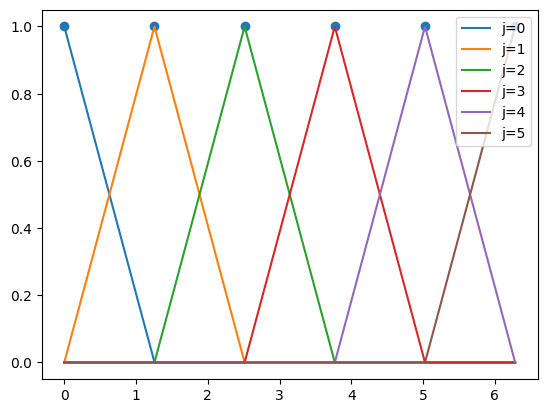

In [263]:
n = 5
t_coloc = np.linspace(0, 2*np.pi, n+1)
psi = psi_for_points(t_coloc)
x = np.linspace(0, 2*np.pi, 1000)
for j in range(n+1):
    plt.plot(x, [psi(j, x_i) for x_i in x], label=f'j={j}')

plt.scatter(t_coloc, [1] * len(t_coloc))

plt.legend()
plt.show()

In [264]:
def gauss_quadrature(a: float, b: float, m: int, f):
    omega = [0.55555556, 0.88888889, 0.55555556]
    t = [-0.77459667, 0, 0.77459667]
    n = 3
    h = (b - a) / m
    I = 0
    for c in [a + j * h for j in range(m)]:
        # I += h * sum([omega[i] * f((2*c + h) / 2 + h * t[i] / 2) for i in range(n)]) / 2
        I += sum([omega[i] * f((2*c + h) / 2 + h * t[i] / 2) for i in range(n)])
    
    return h / 2 * I

# Phi, U code

In [265]:
def find_phi(n: int, m: int, f, silent=True):
    t_coloc = np.linspace(0, 2*np.pi, n+1)
    psi = psi_for_points(t_coloc)

    A = np.zeros((n+1, n+1))
    B = -2 * np.vectorize(f)(t_coloc)

    for i in range(n+1):
        for j in range(n+1):
            #tau or t_coloc_i in psi
            qd = gauss_quadrature(a=0, b=2*np.pi, m=m, f=lambda tau: K(t_coloc[i], tau)*psi(j, tau))
            if not silent:
                print('qd =', qd)
            A[i,j] = psi(j, t_coloc[i]) - qd

    C = np.linalg.solve(A, B)
    if not silent:
        print('A =', A)
        print('B =', B)
        print('C =', C)

    phi = lambda x: sum([C[j] * psi(j, x) for j in range(n+1)])

    return phi



In [266]:
def find_u(n: int, m_phi: int, m_u: int, f, silent=True):
    phi = find_phi(f=f, n=n, m=m_phi, silent=silent)
    u = lambda x: gauss_quadrature(a=0, b=2*np.pi, m=m_u, f=lambda tau: phi(tau) * (gradPhi(x, xi(tau)) @ nu(tau)) * np.linalg.norm(xi_der(tau)))

    return u, phi

In [291]:
def plot_u(u, xmin=-1, xmax=1, ymin=-1, ymax=1, nsteps=20, x=[]):
    ax = plt.subplot(projection='3d')

    X = np.linspace(xmin, xmax, nsteps)
    Y = np.linspace(ymin, ymax, nsteps)
    X, Y = np.meshgrid(X, Y)

    f2 = lambda x, y: u(np.array([x, y]))

    Z = np.vectorize(f2)(X, Y)

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False, alpha=.3)
    plt.colorbar(surf, shrink=0.5, aspect=10)

    for x_i in x:
        ax.scatter(x_i[0], x_i[1], u(x_i), 'r.')

    plt.show()

# Experiments

In [323]:
ns = [8, 16, 32, 64, 128]
#ns = [2**i for i in range(1, 8)]
results = []

# x = xi(4.5)
# x = np.array([1, 1])
x_1 = np.array([0.5, -0.08])
x_2 = np.array([0.3, 0.2])
m_phi, m_u = 40, 40

exact = lambda x: x[0]**2 - x[1]**2
#exact = lambda x: x[0] * x[1]
#exact = lambda x: math.exp(x[0])*math.cos(x[1])
# f = lambda t: exact(xi(t))

#exact = lambda x: Phi(x, np.array([4.7, 4]))
f = lambda t: exact(xi(t))

for n in tqdm(ns):
    u, phi = find_u(n=n, m_phi=m_phi, m_u=m_u, f=f)
    #results.append({'n': n, 'approx': u(x), 'exact': exact(x),'error (1, 0.7)': abs(exact(x_1) - u(x_1))})
    results.append({'n': n, 'error1': abs(exact(x_1) - u(x_1)), 'error2': abs(exact(x_2)-u(x_2))})
    #results.append({'n': n,'approx1': u(x_1), 'exact': exact(x_1), 'error': abs(exact(x_1) - u(x_1))})
df = pd.DataFrame(results)

df

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:54<00:00, 46.88s/it]


,n,error1,error2
0,8,0.077582,0.062016
1,16,0.038196,0.011643
2,32,0.010102,0.003184
3,64,0.002617,0.000729
4,128,0.000732,0.000163


In [324]:
df.to_csv(r'C:\university\Lir\Lir_report\results\tables\result9.csv', index=False)

## Plots

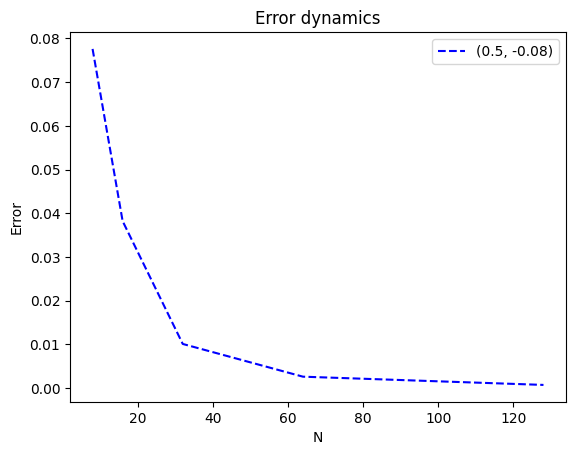

In [319]:
plt.plot(df.n, df.error1, 'b--', label='(0.5, -0.08)')
#plt.plot(df.n, df.error2, 'y--', label='(0.3, 0.2)')

# plt.scatter(df.n, df.error)

plt.xlabel('N')
plt.ylabel('Error')
plt.title('Error dynamics')
plt.legend()

plt.savefig('C:/university/Lir/Lir_report/results/images/error-ex.png')
plt.show()

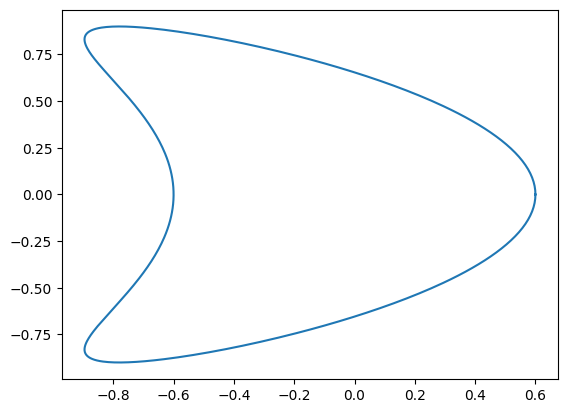

In [276]:
t = np.linspace(0, 2*np.pi, 500)
points = np.array([xi(t_i) for t_i in t])
plt.plot(points[:,0], points[:,1])

plt.show()

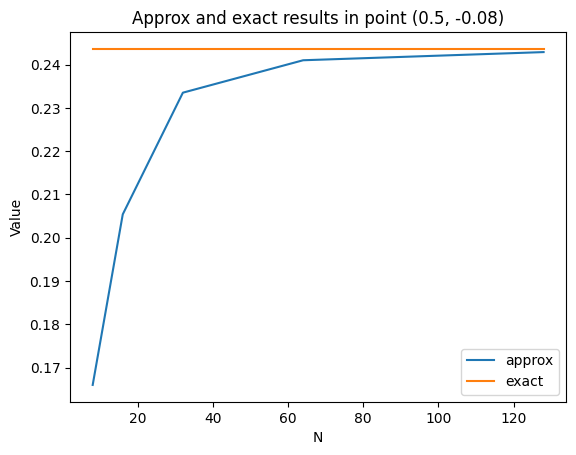

In [320]:
plt.plot(df.n, df.approx1, label='approx')
plt.plot(df.n, df.exact, label='exact')

plt.xlabel('N')
plt.ylabel('Value')
plt.title('Approx and exact results in point (0.5, -0.08)')
plt.legend()

plt.show()

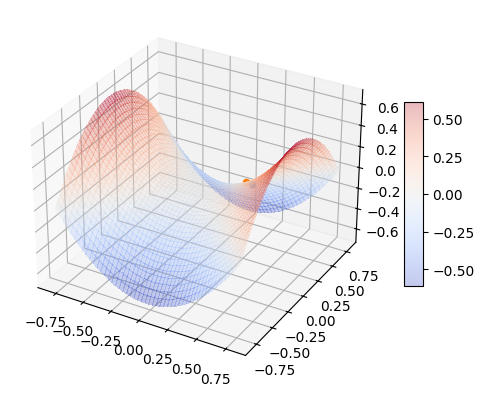

In [321]:
plot_u(exact, xmin=-0.8, xmax=0.8, ymin=-0.8, ymax=0.8, nsteps=50, x=[x_1, x_2])

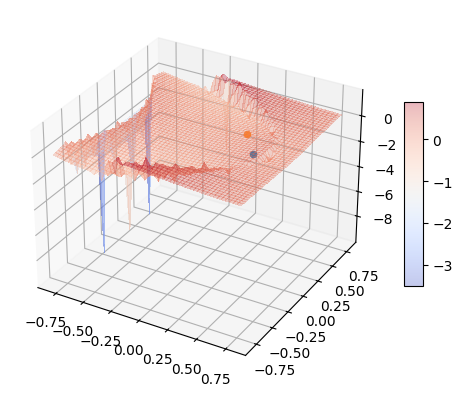

In [322]:
plot_u(u, xmin=-0.8, xmax=0.8, ymin=-0.8, ymax=0.8, nsteps=50, x=[x_1, x_2])

# Misc

In [ ]:
n = 6
A = np.zeros((n+1, n+1))
B = -2* np.ones(n+1)
t_coloc = np.linspace(0, 2*np.pi, n+1)

for i in range(n+1):
    for j in range(n+1):
        A[i,j] = psi(j, t_coloc[i], t_coloc) - gauss_quadrature(a=0, b=2*np.pi, m=40, f=lambda tau: K(t_coloc[i], tau)*psi(j, tau, t_coloc))

C = np.linalg.solve(A, B)

phi = lambda x: sum([C[j] * psi(j, x, t_coloc) for j in range(n+1)])

TypeError: psi_for_points.<locals>.psi() takes 2 positional arguments but 3 were given

In [ ]:
u = lambda x: gauss_quadrature(a=0, b=2*np.pi, m=40, f=lambda tau: phi(tau) * gradPhi(x, xi(tau)) @ nu(tau) * np.linalg.norm(xi_der(tau)))

# x = np.linspace(0, 2*np.pi, 100)
# y = np.frompyfunc(u, 2, 1)
u(xi(.2))

0.5000000012500048

In [ ]:
omega = [0.55555556, 0.88888889, 0.55555556]
tau = [-0.77459667, 0, 0.77459667]
n = 64
a, b = 0, 2*math.pi
h = (b - a) / n
B =  -2* np.ones(n+1)

t_i = np.array([a + j*h for j in range(n+1)])

A = np.zeros((n+1, n+1))
for i in range(n+1):
    for j in range(n+1):
        t = t_i[i]
        s = sum([omega[k] * K(t, math.pi + tau[k]*math.pi) * psi(j, math.pi + tau[k]*math.pi, t_i) for k in range(3)])
        A[i,j] = psi(j, t, t_i) - math.pi * s

print('A=', A)
print('B=', B)
C = np.linalg.solve(A, B)
print('C=', C)

phi = lambda t: sum([C[j] * psi(j, t, t_i) for j in range(n)])

phi = np.frompyfunc(phi, 1, 1)

x = np.linspace(a, b, 100)
plt.plot(x, phi(x))
plt.show()

TypeError: psi_for_points.<locals>.psi() takes 2 positional arguments but 3 were given

In [ ]:
f = lambda tau, x: phi(tau) * (gradPhi(x, xi(tau)) @ nu(tau)) * np.linalg.norm(xi_der(tau))

1.0


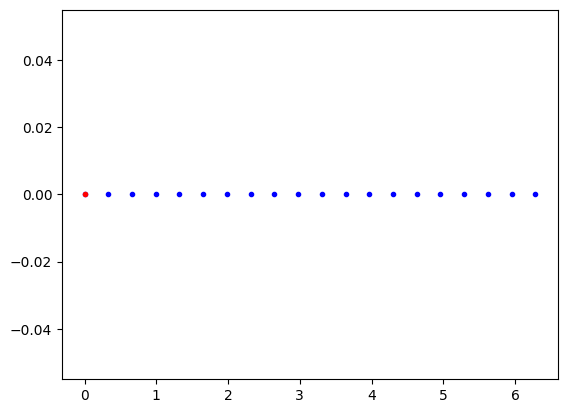

In [ ]:
t_i = np.linspace(0, 2*math.pi, 20)
i, j = 0, 0
t = t_i[i]

print(psi(j, t, t_i))
# print((t_i[3] - t_i[2], h))

plt.plot(t_i, np.zeros(len(t_i)), 'b.')
plt.plot(t, 0, 'r.')
plt.show()

In [ ]:
a = 1.0 # параметр 
rho = 0.5 # радіальна координата
phi = np.pi/4 # кутова координата

def f(psi):
    return math.sin(psi) # підінтегральна функція

def kernel(psi, phi):
    return (a**2 - rho**2) / (a**2 - 2*a*rho*math.cos(phi - psi) + rho**2)

psi_nodes = [-math.pi/math.sqrt(3), 0, math.pi/math.sqrt(3)] # вузли Гаусса
weights = [1, math.sqrt(3), 1] # ваги Гаусса

integral = 0
for i in range(3):
    integral += weights[i] * kernel(psi_nodes[i], phi) * f(psi_nodes[i])  

u = integral / (2*math.pi)
print(u)

0.10288547616514153


0.7853981633974483
1.5707963267948966
2.356194490192345


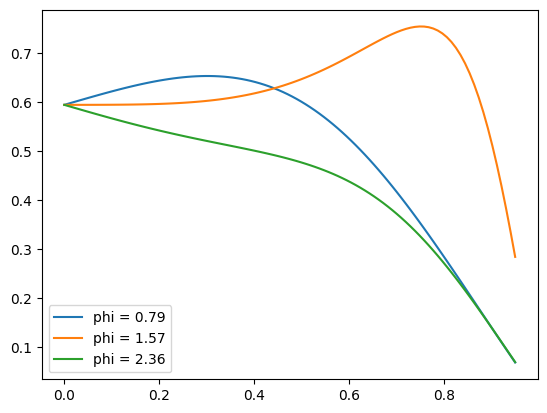

In [ ]:
a = 1.0  
rho = np.linspace(0, 0.95*a, 100)
phi = np.pi/4  

def f(psi):
    return 1

def u(rho, phi):
    integral = 0
    for i in range(3):
        psi = psi_nodes[i] 
        integral += weights[i] * kernel(psi, phi) * f(psi)
    return integral / (2*math.pi)

for phi in [np.pi/4, np.pi/2, 3*np.pi/4]:
    print(phi)
    u_vals = u(rho, phi)
    plt.plot(rho, u_vals, label=f'phi = {phi:.2f}')

# plt.set_xlabel('\rho')
# plt.set_ylabel('u(\rho, \phi)')  
plt.legend()

plt.show()

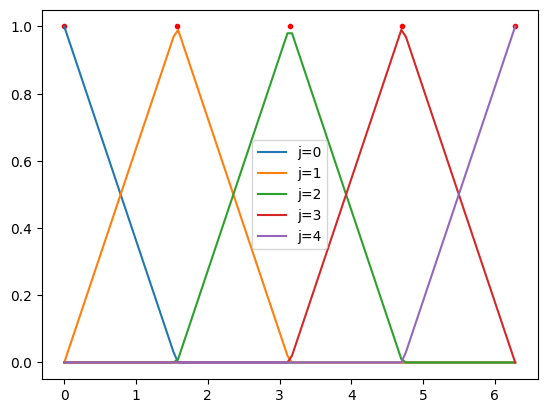

In [ ]:
n = 4
a, b = 0, 2*math.pi
h = (b - a) / n

t_i = np.array([a + j*h for j in range(n+1)])

for p in t_i:
    plt.plot(p, 1, 'r.')

x = np.linspace(a, b, 100)
for j in range(n+1):
    plt.plot(x, [psi(j, t, t_i) for t in x], label=f'j={j}')

plt.legend()

plt.show()